# Import Libraries

In [1]:
# import custom functions
from functions_01 import *

# set plots params
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # change plot appearances

# customisations as ref, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (12, 6) # set a figsize greater than default
mpl.rcParams["lines.linewidth"] = 2 # adjust line width
mpl.rc("font", family = "monospace", monospace = ["DejaVu Sans Mono"])
mpl.rc("axes", titlelocation = "left", titlepad = 12, titleweight = "bold")

# Checking on the PostgreSQL Server

Run a custom script to check if the `PostgreSQL` server is started, else start it.

In [2]:
!bash $MYBINS/pg_server_status


==> Postgres server is already running.

PostgreSQL binary:/usr/local/Cellar/postgresql/13.3/bin/postgres
Server directory:/usr/local/var/postgres


# Retrieve Daily Datasets

Two datasets are retrieved: the daily outflow and the daily outflow for each station.

In [3]:
# arguments are specified: a series for each station is retrieved
station_daily_outflow = (
    retrieve_bike_flow(station_column = {"nome_stazione_prelievo" : "stazione_partenza"})
    .pipe(pivot_bike_flow, cols = "stazione_partenza")
    .convert_dtypes() # make double into integers
)

station_daily_outflow.head()

,Accursio - Portello,Adamello - Lorenzini,Alserio - Cola Montano,Amendola M1,Angilberto - Comacchio,Aquileia,Arcimboldi - Innovazione,Arcivescovado,Arco della Pace 1 - Bertani,Arco della Pace 2 - Pagano,...,Verrocchio - Juvara,Vesuvio - Lipari,Vigliani - Scarampo,Villapizzone FFSS - Lambruschini,Vittor Pisani,XXII Marzo,XXIV Maggio,XXV Aprile,Zara M3,Zavattari - Tempesta
giorno_partenza,,,,,,,,,,,,,,,,,,,,,
2019-07-01,25,25,44,37,4,19,10,72,56,36,...,31,30,9,3,69,23,34,73,27,13
2019-07-02,33,24,46,40,10,20,8,82,72,38,...,26,40,13,6,67,24,52,85,14,18
2019-07-03,38,18,35,42,9,15,13,71,58,42,...,20,39,13,1,74,23,31,76,21,15
2019-07-04,39,19,42,27,8,17,7,104,63,53,...,26,36,13,3,69,28,3,71,18,17
2019-07-05,27,22,42,40,8,17,5,58,54,52,...,23,38,11,3,64,40,45,74,17,16


In [4]:
# when no argument is specified, daily data for Milan is retrieved
daily_outflow = retrieve_bike_flow()
daily_outflow.head()

,count
giorno_partenza,
2019-07-01,9977
2019-07-02,11408
2019-07-03,9719
2019-07-04,10548
2019-07-05,10037


# Filter out invalid data

(Quick note: since the index is a datetime index, we can subset the data very easily by using this notation: `daily_outflow.loc["2019-09"]`.)

First, let's check if the dates are indeed those of the third quarter:

In [5]:
daily_outflow.tail()

,count
giorno_partenza,
2019-09-27,13863
2019-09-28,6593
2019-09-29,5659
2019-09-30,12642
2019-10-01,117


We need to remove the last line as it contains data about the first trips on october 1st:

In [6]:
daily_outflow = daily_outflow.loc[daily_outflow.index != "2019-10"]

## Trend analysis

Let's plot the data:

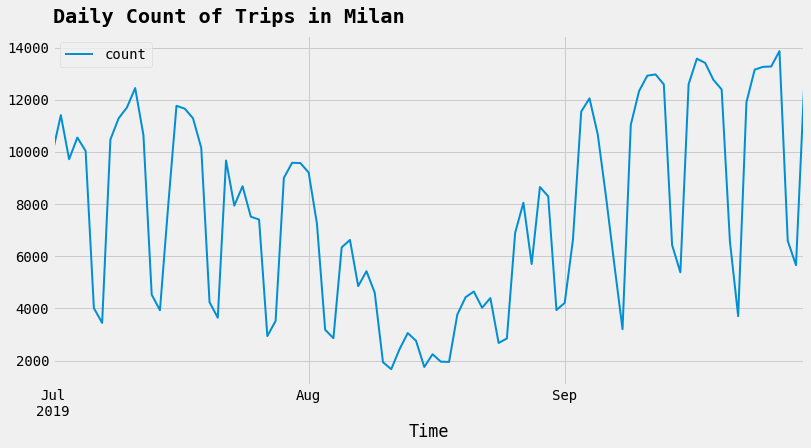

In [7]:
make_ts_plot(daily_outflow)

Unsurprisingly, the number of usages falls around August 15th. The data clearly displays a trend, as well as weekly seasonality. Let's plot some rolling statistics, too:

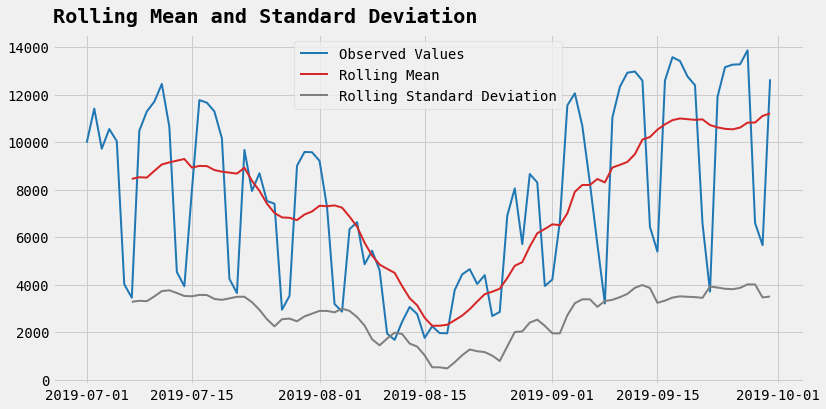

In [8]:
plot_rolling_statistics(daily_outflow)
    

We can also look at the boxplot distribution across each day of the week:

In [9]:
daily_outflow.head()

,count
giorno_partenza,
2019-07-01,9977
2019-07-02,11408
2019-07-03,9719
2019-07-04,10548
2019-07-05,10037


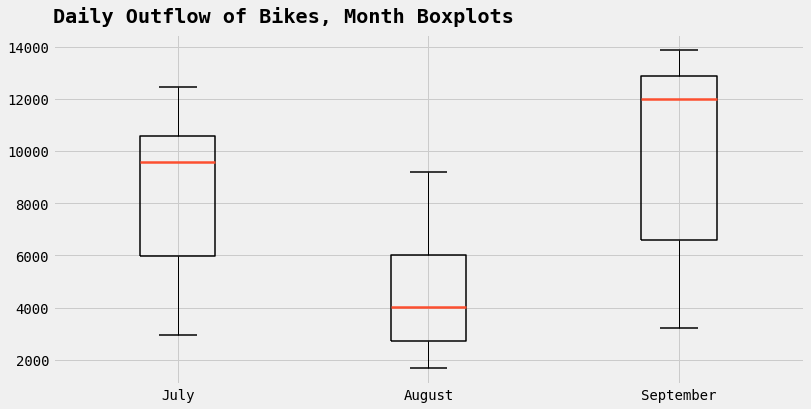

In [10]:
subunits_boxplot(daily_outflow, y = "count", time_subunit = "month")

# Autocorrelation

Let's have a look at the autocorrelation function, before proceeding.

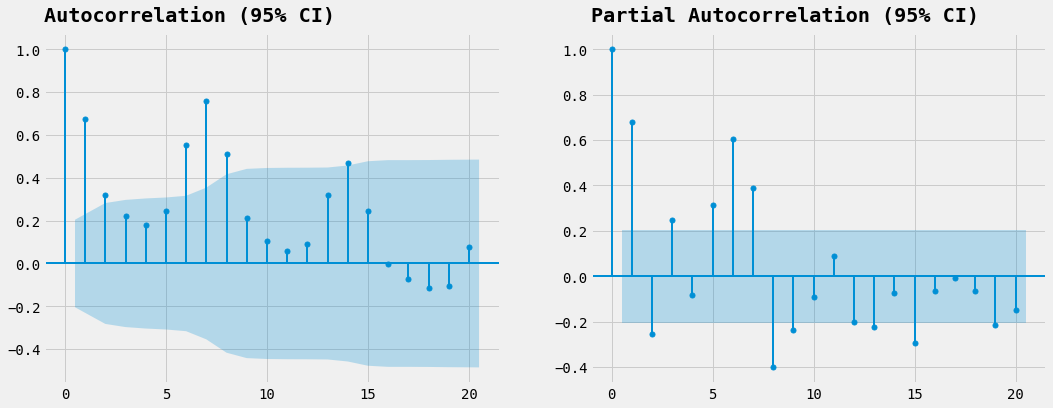

In [11]:
plot_acf_and_pacf(daily_outflow["count"])

Both plots show that the data is (unsurprisingly) non stationary. Besides, the ACF plot shows two components of the time-series:

* a trend, as the autocorrelation is declining;
* a (strong) seasonal component on the seventh lag - i.e., a stron weekly dependence.

The correlation quickly becomes statistically indistinguisheable from zero.

Let's perform a Dickey Fuller test.

# Advanced Dickey Fuller Test

In [12]:
perform_adfuller(daily_outflow["count"])


        Test Statistics: -1.3164000164404412
        p-value: 0.8838130376998452

        Number of lags: 8
        Number of observations: 83

        Critical Value (1%): -4.072204696661519
        Critical Value (5%): -3.464777396530526
        Critical Value (10%): -3.158810696553087

        AIC: 1397.1737393790502

        The series is non-stationary 
        


The test statistic is greater than any critical value: in other words, we cannot reject the null hypothesis and the series is indeed non-stationary.

# Time-Series Decomposition

There are several alternatives:

* Apply a transformation (e.g., take logs);
* Subtract the rolling average (it can work here, since the frequency is clear. It becomes more complex in case of high-frequency data: which window shall be selected?)

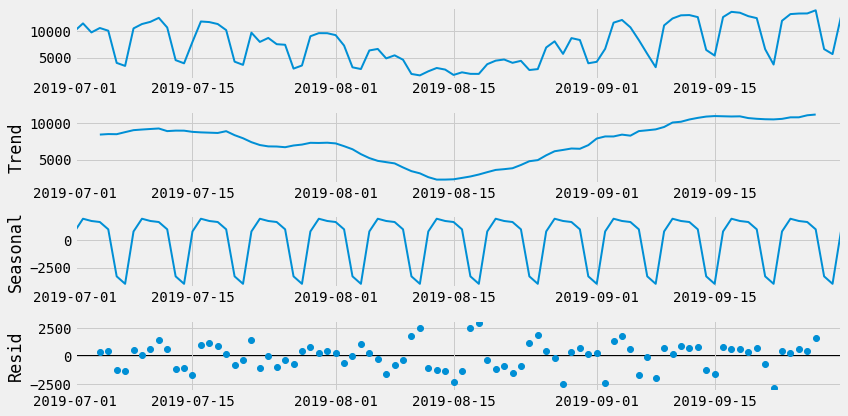

In [13]:
tsa.seasonal_decompose(daily_outflow, model = "additive").plot();